# Prospecção de Dados (Data Mining) DI/FCUL - HA1

## First Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP: `02`

* João Martins, 62532 - Hours worked on the project: 16
* Rúben Torres, 62531 - Hours worked on the project: 16
* Nuno Pereira, 56933 - Hours worked on the project: 16

The purpose of this Home Assignment is:
* Read a Data file with a Set of Texts
* Compute similarities between texts
* Perform simple classification of texts using a Naive Bayes Classifier

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

## 1. Read the Dataset

The dataset is the file `Sentences_75Agree.txt` from the [Financial Sentiment Analysis database on Hugging Face](https://huggingface.co/datasets/financial_phrasebank)

* Read the dataset and separate them by unique documents (one document per line)
* The last word of each document is the class and it **must be removed from the document** but kept separate for use in the classification tasks below
    * classes can be `.@positive`, `.@negative` or `.@neutral`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import unicodedata
from math import log2
from random import sample, shuffle
from scipy.stats import norm
from sklearn.metrics import (
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
)
from statistics import mean, stdev
from typing import List, Tuple


FILE_NAME: str = "Sentences_75Agree.txt"
CLASS_DELIMITER: str = "@"


def classify_document(document: str) -> dict[str, str]:
    s: str = document.strip().split(CLASS_DELIMITER)
    return {"document": s[0], "class": s[-1]}


documents: list[str] = open(FILE_NAME, encoding="ISO-8859-15").readlines()
documents_classified: list[dict[str, str]] = [
    classify_document(document) for document in documents
]

## 2. Compute similarities between texts

* Compute the TF.IDF of all words in texts
* compute the average similarity beween texts
* Plot the document similarity distribution (suggestion use [boxplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html) or [histograms](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) or [histograms with density](https://matplotlib.org/stable/gallery/statistics/histogram_features.html))
* Comment your results

In [2]:
# ========== CORPUS Start ========== #


def basic_word_tokenizer(text: str) -> list[str]:
    return text.split()


def remove_accents(text: str) -> str:
    nfkd_form: str = unicodedata.normalize("NFKD", text)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])


def remove_stuff(text: str) -> str:
    for c in '\\\t0123456789Ææœ—‘’\ufeff{|}“”.,()$£%&[]?@#!=;*+–"ǁ':
        text = text.replace(c, "")
    text = text.replace("-", " ")
    return text


def get_words_from_text(text: str) -> list[str]:
    text = text.strip().lower()
    text = remove_accents(text)
    text = remove_stuff(text)
    text = text.lower()
    return basic_word_tokenizer(text)


def get_words_from_corpus(corpus: list[str]) -> list[list[str]]:
    return [get_words_from_text(text) for text in corpus]


# ========== CORPUS End ========== #

# ========== TF Start ========== #


def word_counter(words: list[str]) -> dict[str, int]:
    unique_words: set[str] = set(words)
    counter: dict[str, int] = dict(zip(unique_words, [0] * len(unique_words)))
    for word in words:
        counter[word] += 1
    return counter


def TF(word_counts: dict[str, int]) -> dict[str, int]:
    counts: list[int] = list(word_counts.values())
    if len(counts) == 0:
        return {}
    counts_max: int = max(counts)
    return dict(zip(word_counts.keys(), [count / counts_max for count in counts]))


def TF_all(words_texts: list[list[str]]) -> list[dict[str, int]]:
    return [TF(word_counter(words)) for words in words_texts]


# ========== TF End ========== #

# ========== IDF Start ========== #


def IDF_all(words_texts_sets: list[set[str]]) -> dict[str, float]:
    all_words: set[str] = set.union(*words_texts_sets)
    counter: dict[str, int] = dict(zip(all_words, [0] * len(all_words)))
    total_number_of_documents: int = len(words_texts_sets)
    for words in words_texts_sets:
        for word in words:
            counter[word] += 1
    return {word: log2(total_number_of_documents / counter[word]) for word in counter}


# ========== IDF End ========== #

# ========== TF-IDF Start ========== #


def TF_IDF_cosine_similarity(
    idx1: int,
    idx2: int,
    words_texts_sets: list[set[str]],
    all_tfs: list[dict[str, int]],
    all_idfs: dict[str, float],
) -> float:
    text1: set[str] = words_texts_sets[idx1]
    text2: set[str] = words_texts_sets[idx2]
    common_words: set[str] = text1 & text2
    if len(common_words) == 0:
        return 0.0

    tfs1: dict[str, int] = all_tfs[idx1]
    tfs2: dict[str, int] = all_tfs[idx2]
    common_tfidfs: list[float] = [
        tfs1[word] * tfs2[word] * all_idfs[word] * all_idfs[word]
        for word in common_words
    ]

    tfidfs2_1 = np.array([tfs1[word] * all_idfs[word] for word in text1]) ** 2
    tfidfs2_2 = np.array([tfs2[word] * all_idfs[word] for word in text2]) ** 2

    return sum(common_tfidfs) / (np.sqrt(tfidfs2_1.sum()) * np.sqrt(tfidfs2_2.sum()))


def text_similarities(
    words_texts_sets: list[set[str]],
    all_tfs: list[dict[str, int]],
    all_idfs: dict[str, float],
) -> list[tuple[float, tuple[int, int]]]:
    total_number_of_documents: int = len(words_texts_sets)
    return [
        (TF_IDF_cosine_similarity(i, j, words_texts_sets, all_tfs, all_idfs), (i, j))
        for i in range(total_number_of_documents - 1)
        for j in range(i + 1, total_number_of_documents)
    ]


# ========== TF-IDF End ========== #

# ========== Distribution Start ========== #


def plot_distribution(mean: float, stdev: float) -> None:
    x = np.linspace(0.0, 1.0, 100)
    y = norm.pdf(x, mean, stdev)

    plt.plot(x, y, label="Distribution", color="blue")
    plt.axvline(x=mean, linestyle="--", color="red", label="Mean")
    plt.title(f"Distribution (mean={mean} and stdev={stdev})")
    plt.xlabel("Similarities (between texts)")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.show()


# ========== Distribution End ========== #

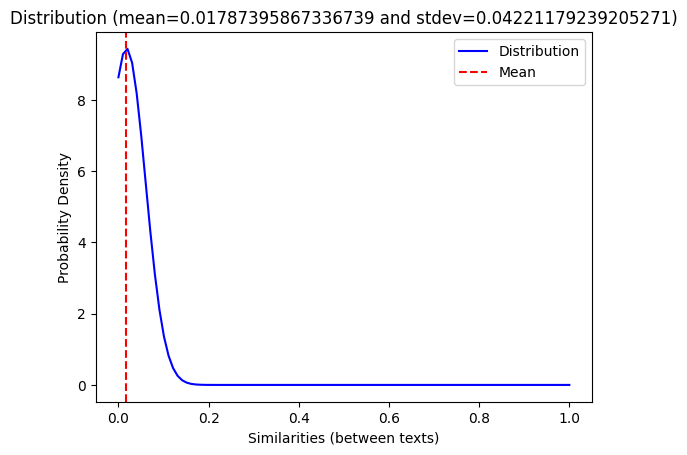

In [3]:
corpus: list[str] = [
    document_classified["document"] for document_classified in documents_classified
]

words_texts: list[list[str]] = get_words_from_corpus(corpus)
all_tfs: list[dict[str, int]] = TF_all(words_texts)

words_texts_sets: list[set[str]] = [set(words) for words in words_texts]
all_idfs: dict[str, float] = IDF_all(words_texts_sets)

similarities: list[tuple[float, tuple[int, int]]] = text_similarities(
    words_texts_sets, all_tfs, all_idfs
)

values: list[float] = [min(1.0, similarity) for similarity, _ in similarities]
values_mean: float = mean(values)
values_stdev: float = stdev(values)
plot_distribution(values_mean, values_stdev)

### Your short analysis here

Looking at the Distribution Plot, we can conclude that the documents are not that similar to each other (as most documents have a similarity score of ≈ 0.018).

## 3. Make a Naive Bayes Classifier 

* Split dataset randomly into training and testing (20% for testing)
* Train a Naive Bayes Model and do some sensitivity analysis on the hyperparameters 
* Evaluate your results with the testing set

In [4]:
def make_train_test(
    X: list[str], y: list[int], r: float = 0.2
) -> Tuple[list[str], list[int], list[str], list[int]]:
    N: int = len(X)
    test_idx: set = set(sample(range(N), int(N * r)))
    train_idx: list = list(set(range(N)) - test_idx)
    test_idx: list = list(test_idx)
    shuffle(train_idx)
    shuffle(test_idx)
    train_set_X: list[str] = [X[i] for i in train_idx]
    train_set_y: list[str] = [y[i] for i in train_idx]
    test_set_X: list[str] = [X[i] for i in test_idx]
    test_set_y: list[str] = [y[i] for i in test_idx]
    return train_set_X, train_set_y, test_set_X, test_set_y


def calc_prior_counts(labels: list[int]) -> list[float]:
    yv, yc = np.unique(labels, return_counts=True)
    priors: np.ndarray = np.ones(len(yv))
    priors[yv] = yc
    return priors


def calc_all_words(words_text_sets: list[set]) -> list[str]:
    all_words: set = set()
    for words in words_text_sets:
        all_words |= words
    return all_words


def init_likelihood_counts(docs_words: list[list[str]], n_labels: int) -> dict:
    all_words: list[str] = calc_all_words(docs_words)
    L_hoods: dict = {}
    for w in all_words:
        L_hoods[w] = np.zeros(n_labels)
    return L_hoods


def update_likelihood_counts(L_hoods: dict, words: list[str], label: int) -> None:
    for word in words:
        L_hoods[word][label] += 1


def calc_likelihood_counts(docs_words: list[list[str]], labels: list[int]) -> dict:
    n_labels: int = len(set(labels))
    L_hoods: dict = init_likelihood_counts(docs_words, n_labels)
    for i, words in enumerate(docs_words):
        update_likelihood_counts(L_hoods, words, labels[i])
    return L_hoods


def classify_new_document(
    words: list[str], priors: np.ndarray, L_hoods: dict, alpha: float
) -> list[float]:
    res: np.ndarray = priors / priors.sum()
    alpha_vec: np.ndarray = np.ones(len(res)) * alpha
    for word in words:
        if word in L_hoods:
            res *= L_hoods[word] / L_hoods[word].sum() + alpha_vec
    return res / res.sum()


def classify_documents(
    docs: list[list[str]], priors: np.ndarray, L_hoods: dict, alpha: float = 0
) -> list[int]:
    return [
        classify_new_document(words, priors, L_hoods, alpha).argmax(axis=0)
        for words in docs
    ]


def calc_posterior(data: list[str], priors: np.ndarray, L_hoods: dict) -> dict:
    probs: np.ndarray = np.zeros(len(priors))
    for j, yp in enumerate(priors.keys()):
        probs[j] = priors[yp]
        for i, d in enumerate(data):
            probs[j] *= L_hoods[(i, d, yp)]
    # scaling to 1.0
    probs = probs / np.sum(probs)
    return {yp: probs[j] for j, yp in enumerate(priors.keys())}


def model_evaluation(y_test: list[int], preds: list[int]) -> None:
    print("The Accuracy score is: %7.4f" % accuracy_score(y_test, preds))
    print("The F1 score is: %7.4f" % f1_score(y_test, preds, average="weighted"))
    print("The MCC score is: %7.4f" % matthews_corrcoef(y_test, preds))
    print(
        "The precision score is: %7.4f"
        % precision_score(y_test, preds, average="weighted")
    )
    print(
        "The recall score is: %7.4f" % recall_score(y_test, preds, average="weighted")
    )
    print(confusion_matrix(y_test, preds))


def plot_diferent_aplha_values(
    x_test: list[str],
    y_test: list[int],
    PC: np.ndarray,
    LHC: dict,
    preds: list[int],
    alphas: list[float],
) -> None:
    f1_scores: list[float] = []
    matthews_corrcoefs: list[float] = []
    precision_scores: list[float] = []
    recall_scores: list[float] = []

    for i in alphas:
        preds = classify_documents(x_test, PC, LHC, alpha=i)
        f1_scores.append(f1_score(y_test, preds, average="weighted", zero_division=1))
        matthews_corrcoefs.append(matthews_corrcoef(y_test, preds))
        precision_scores.append(
            precision_score(y_test, preds, average="weighted", zero_division=1)
        )
        recall_scores.append(
            recall_score(y_test, preds, average="weighted", zero_division=1)
        )

    plt.plot(alphas, f1_scores, color='blue', marker = "o", label="F1")
    plt.plot(alphas, matthews_corrcoefs, color='green', marker = "o", label="mathews_corr")
    plt.plot(alphas, precision_scores, color='red', marker = "o", label="precision")
    plt.plot(alphas, recall_scores, color='black', marker = "o", label="recall")
    plt.legend(loc='best')
    plt.title("Model evaluation for different alpha values")
    plt.xlabel("Alpha values")
    plt.ylabel("Scores")
    plt.grid()
    plt.show()


def plot_class_balance(data: list[int]) -> None:
    classes = ['negative', 'neutral', 'positive']
    
    yv, yc=np.unique(data, return_counts=True)
    print(yc)
    plt.bar(classes, yc, color ='blue', width = 0.6)
    plt.title("Number of samples attributed to each class")
    plt.xlabel("Nº classes")
    plt.ylabel("No. of instances")
    plt.show()

The Accuracy score is:  0.7203
The F1 score is:  0.6695
The MCC score is:  0.4583
The precision score is:  0.7547
The recall score is:  0.7203
[[  9  59  16]
 [  1 403   5]
 [  0 112  85]]


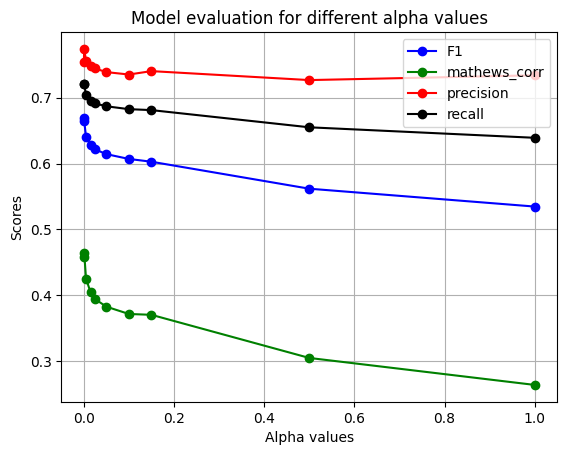

[ 420 2146  887]


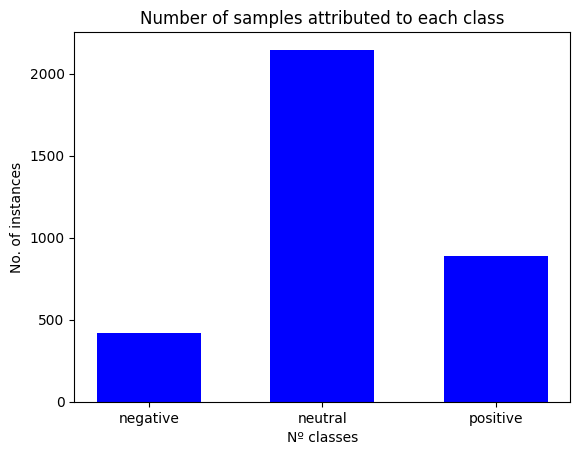

In [5]:
class_encoding: dict = {"negative": 0, "neutral": 1, "positive": 2}

y_corpus: list[str] = [
    class_encoding[document_classified["class"]]
    for document_classified in documents_classified
]
x_corpus = words_texts_sets

x_train, y_train, x_test, y_test = make_train_test(x_corpus, y_corpus, r=0.2)

PC: list[float] = calc_prior_counts(y_train)
LHC: list[float] = calc_likelihood_counts(x_train, y_train)

preds: list[int] = classify_documents(x_test, PC, LHC, alpha=0.0001)

model_evaluation(y_test, preds)

alphas: list[int] = [0.0001, 0.001, 0.005, 0.015, 0.025, 0.05, 0.1, 0.15, 0.5, 1.0]
plot_diferent_aplha_values(x_test, y_test, PC, LHC, preds, alphas)
plot_class_balance(y_corpus)


## 4. Discuss your findings [to fill on your own]

* Comment your results above
* Discuss how could they be used in a Big Data environment

We experimented with the Naive Bayes hyperparameter (alpha), and the closer the alpha was to 0, the better the metrics performed.

Analysing the second plot (bar graph), we can clearly see that we have an imbalanced dataset (the neutral documents represent ≈ 62.15% of the total documents):
* 3453 total documents
* 2146 neutral documents
* 887 positive documents
* 420 negative documents

In the Big Data Environment, Naive Bayes is a really good model, as it's a simple and stable model, that is very fast to learn and make predictions, and most importantly is updatable (useful for high input/volume of data and/or real-time data). On the other hand, calculating Text Similarities (with TF-IDF) is only feasible if we use/employ some form of distributed computing (in the cloud, for example).